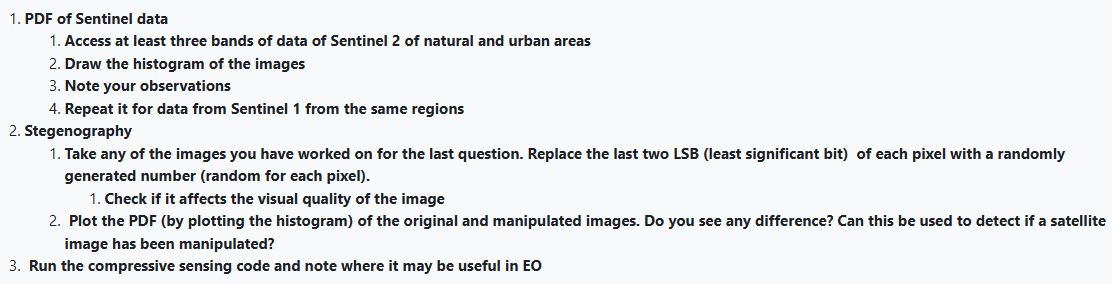

## Sentinel-2 urban and rural/forest areas analysis:

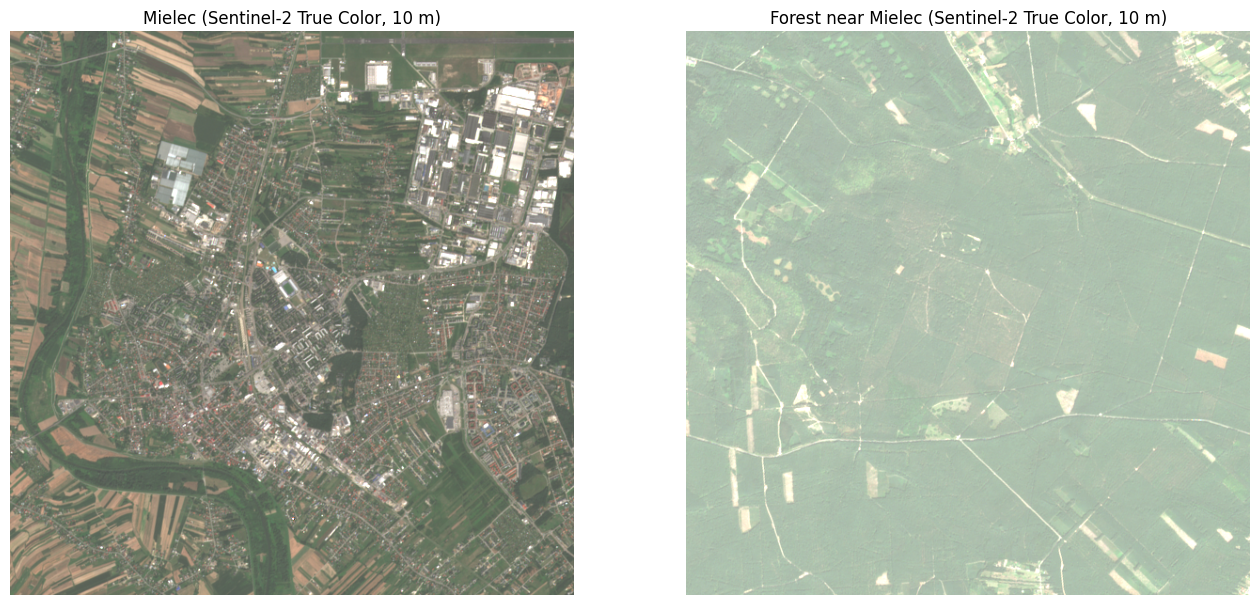

In [ ]:
import glob
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.windows import from_bounds
from pyproj import Transformer

# Paths to the 10m bands for both urban and rural areas
folder_m = "C:\\Users\\kacpe\\Desktop\\Studia\\ML\\S2A_MSIL2A_20250813T094041_N0511_R036_T34UEA_20250813T112012.SAFE\\GRANULE\\L2A_T34UEA_A052972_20250813T094043\\IMG_DATA\\R10m"
folder_fm = "C:\\Users\\kacpe\\Desktop\\Studia\\ML\\S2A_MSIL2A_20250813T094041_N0511_R036_T34UEA_20250813T112012.SAFE\\GRANULE\\L2A_T34UEA_A052972_20250813T094043\\IMG_DATA\\R10m"

# Paths to the r g and b bands 
band_paths_m = {b: glob.glob(f"{folder_m}/*_{b}_10m.jp2")[0] for b in ["B04", "B03", "B02"]}
band_paths_fm = {b: glob.glob(f"{folder_fm}/*_{b}_10m.jp2")[0] for b in ["B04", "B03", "B02"]}


lon_m, lat_m = 21.43630, 50.29630   # Mielec coordinates
lon_fm, lat_fm = 21.55724, 50.28835   # Forest near Mielec coordinates

# Transforming the image coordinates from lat/lon to UTM, taking 3km x 3km area around the point
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32634", always_xy=True)
x_m, y_m = transformer.transform(lon_m, lat_m)
x_fm, y_fm = transformer.transform(lon_fm, lat_fm)
dx = 3000   
dy = 3000   
xmin_m, ymin_m, xmax_m, ymax_m = x_m - dx, y_m - dy, x_m + dx, y_m + dy
xmin_fm, ymin_fm, xmax_fm, ymax_fm = x_fm - dx, y_fm - dy, x_fm + dx, y_fm + dy

# Helper functions to load only the cropped area of interest instead of whole image
def read_crop(path, bounds):
    with rasterio.open(path) as src:
        window = from_bounds(*bounds, transform=src.transform)
        data = src.read(1, window=window)
    return data


# Crop each band for both pictures
b4_crop_m = read_crop(band_paths_m["B04"], (xmin_m, ymin_m, xmax_m, ymax_m))  # R
b3_crop_m = read_crop(band_paths_m["B03"], (xmin_m, ymin_m, xmax_m, ymax_m))  # G
b2_crop_m = read_crop(band_paths_m["B02"], (xmin_m, ymin_m, xmax_m, ymax_m))  # B


b4_crop_fm = read_crop(band_paths_fm["B04"], (xmin_fm, ymin_fm, xmax_fm, ymax_fm))  # R
b3_crop_fm = read_crop(band_paths_fm["B03"], (xmin_fm, ymin_fm, xmax_fm, ymax_fm))  # G
b2_crop_fm = read_crop(band_paths_fm["B02"], (xmin_fm, ymin_fm, xmax_fm, ymax_fm))  # B


# Stack, normalize, remove outliers
cropped_rgb_m = np.dstack((b4_crop_m, b3_crop_m, b2_crop_m)).astype(np.float32)
cropped_rgb_m /= np.percentile(cropped_rgb_m, 99)
cropped_rgb_m = np.clip(cropped_rgb_m, 0, 1)

cropped_rgb_fm = np.dstack((b4_crop_fm, b3_crop_fm, b2_crop_fm)).astype(np.float32)
cropped_rgb_fm /= np.percentile(cropped_rgb_fm, 99)
cropped_rgb_fm = np.clip(cropped_rgb_fm, 0, 1)

# Plot both images side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[1].imshow(cropped_rgb_fm)
axs[1].set_title("Forest near Mielec (Sentinel-2 True Color, 10 m)")
axs[1].axis("off")
axs[0].imshow(cropped_rgb_m)
axs[0].set_title("Mielec (Sentinel-2 True Color, 10 m)")
axs[0].axis("off")
plt.show()


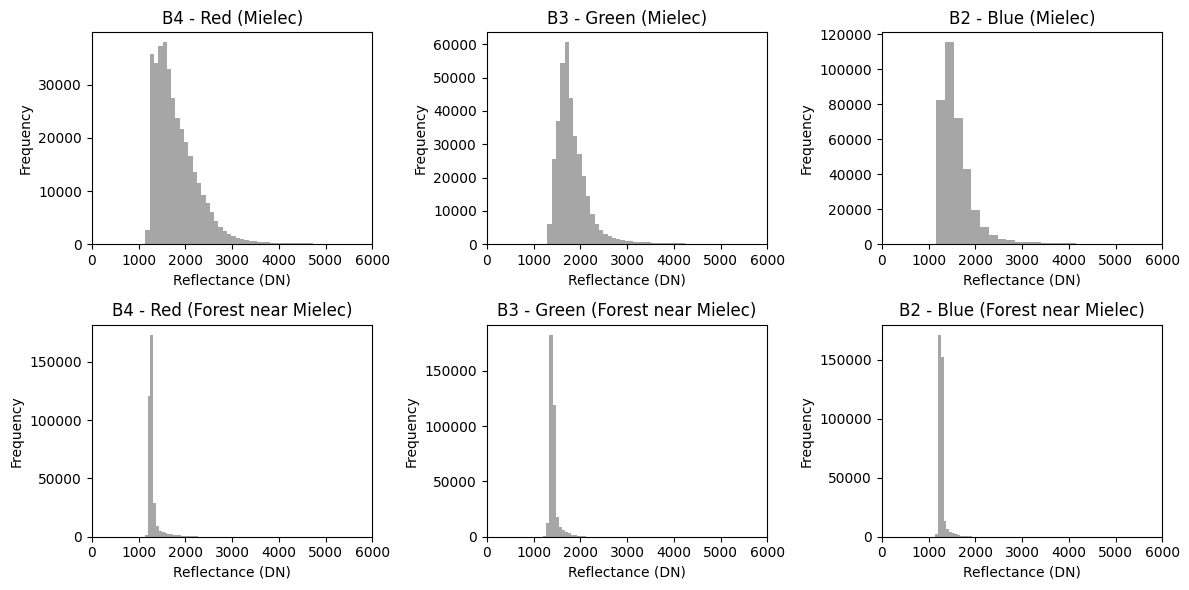

In [ ]:
# Plotting all the histograms and trying to find out something interesting.

bands_m = [b4_crop_m, b3_crop_m, b2_crop_m]
bands_fm = [b4_crop_fm, b3_crop_fm, b2_crop_fm]
names = ["B4 - Red", "B3 - Green", "B2 - Blue"]

plt.figure(figsize=(12, 6))

for i, (band, name) in enumerate(zip(bands_m, names)):
    plt.subplot(2, 3, i+1)
    plt.hist(band.flatten(), bins=100, color="gray", alpha=0.7)
    plt.title(name + " (Mielec)")
    plt.xlim(0,6000)
    plt.xlabel("Reflectance (DN)")
    plt.ylabel("Frequency")

for i, (band, name) in enumerate(zip(bands_fm, names)):
    plt.subplot(2, 3, i+4)
    plt.hist(band.flatten(), bins=50, color="gray", alpha=0.7)
    plt.title(name + " (Forest near Mielec)")
    plt.xlim(0,6000)
    plt.xlabel("Reflectance (DN)")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


The Forest area shows a bit less variance - tighter grouping of reflectance values comparing to Mielec urban area.


## Sentinel-1 urban and rural/forest areas analysis:

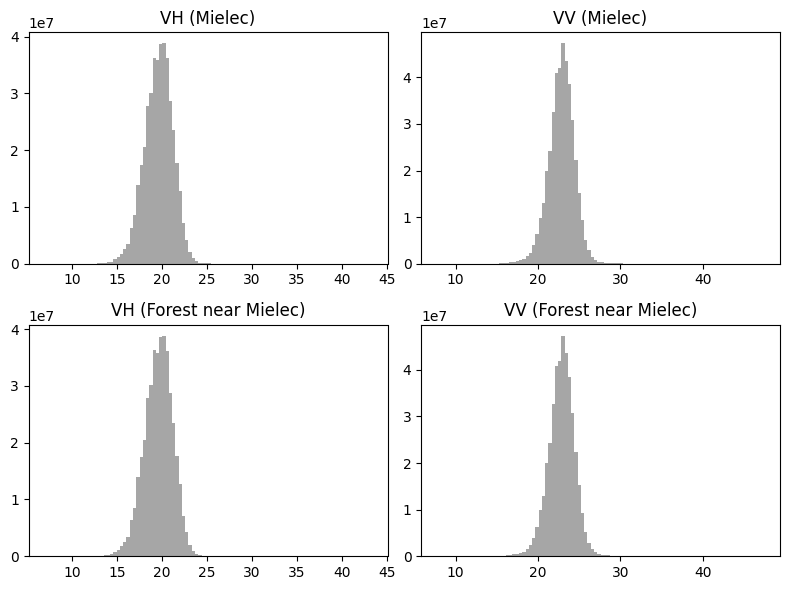

In [25]:
import rasterio
import os
import numpy as np
import matplotlib.pyplot as plt
from rasterio.windows import from_bounds, Window
from pyproj import Transformer

lon_m, lat_m = 21.43630, 50.29630   # Mielec coordinates
lon_fm, lat_fm = 21.55724, 50.28835   # Forest near Mielec coordinates

dx, dy    = 3000, 3000
s1_file_vh_m = "C:\\Users\\kacpe\\Desktop\\Studia\\ML\\S1A_IW_GRDH_1SDV_20251220T161903_20251220T161928_062401_07D10A_966C.SAFE\\measurement\\s1a-iw-grd-vh-20251220t161903-20251220t161928-062401-07d10a-002.tiff"
s1_file_vv_m = "C:\\Users\\kacpe\\Desktop\\Studia\\ML\\S1A_IW_GRDH_1SDV_20251220T161903_20251220T161928_062401_07D10A_966C.SAFE\\measurement\\s1a-iw-grd-vv-20251220t161903-20251220t161928-062401-07d10a-001.tiff"
s1_file_vh_fm = "C:\\Users\\kacpe\\Desktop\\Studia\\ML\\S1A_IW_GRDH_1SDV_20251220T161903_20251220T161928_062401_07D10A_966C.SAFE\\measurement\\s1a-iw-grd-vh-20251220t161903-20251220t161928-062401-07d10a-002.tiff"
s1_file_vv_fm = "C:\\Users\\kacpe\\Desktop\\Studia\\ML\\S1A_IW_GRDH_1SDV_20251220T161903_20251220T161928_062401_07D10A_966C.SAFE\\measurement\\s1a-iw-grd-vv-20251220t161903-20251220t161928-062401-07d10a-001.tiff"


def read_window(path, lon, lat, dx, dy):
    with rasterio.open(path) as src:
        
        crs_raster = src.crs or "EPSG:4326"
        transformer = Transformer.from_crs("EPSG:4326", crs_raster, always_xy=True)
        x, y = transformer.transform(lon, lat)
        transform = src.transform
        W, H = src.width, src.height
        if abs(transform.a) < 0.001: 
            dx_deg = dx / 111320
            dy_deg = dy / 111320
        else:
            dx_deg = dx
            dy_deg = dy

        xmin, ymin, xmax, ymax = x - dx_deg, y - dy_deg, x + dx_deg, y + dy_deg
        try:
            win = from_bounds(xmin, ymin, xmax, ymax, transform=transform)
        except Exception:
            rleft, rbottom, rright, rtop = src.bounds.left, src.bounds.bottom, src.bounds.right, src.bounds.top
            xmin = max(xmin, rleft)
            xmax = min(xmax, rright)
            ymin = max(ymin, rbottom)
            ymax = min(ymax, rtop)
            if xmin >= xmax or ymin >= ymax:
                
                win = Window(0, 0, W, H)
            else:
                win = from_bounds(xmin, ymin, xmax, ymax, transform=transform)

        col_off = int(np.floor(win.col_off))
        row_off = int(np.floor(win.row_off))
        width = int(np.ceil(win.width))
        height = int(np.ceil(win.height))
        col_off = max(0, min(col_off, max(0, W - 1)))
        row_off = max(0, min(row_off, max(0, H - 1)))
        width = max(0, min(width, W - col_off))
        height = max(0, min(height, H - row_off))
        if width == 0 or height == 0:
           
            return np.empty((0, 0), dtype=np.float32), crs_raster

        win = Window(col_off, row_off, width, height)
        arr = src.read(1, window=win, boundless=True, fill_value=np.nan).astype(np.float32)
        arr[arr <= 0] = np.nan
        return arr, crs_raster


s1_img_vh_m, crs1 = read_window(s1_file_vh_m, lon_m, lat_m, dx, dy)
s1_img_vv_m, crs2 = read_window(s1_file_vv_m, lon_m, lat_m, dx, dy)
s1_img_vh_fm, crs3 = read_window(s1_file_vh_fm, lon_fm, lat_fm, dx, dy)
s1_img_vv_fm, crs4 = read_window(s1_file_vv_fm, lon_fm, lat_fm, dx, dy)


if s1_img_vh_m.size == 0 and s1_img_vv_m.size > 0:
    s1_img1 = np.full_like(s1_img_vv_m, np.nan)
elif s1_img_vv_m.size == 0 and s1_img_vh_m.size > 0:
    s1_img_vv_m = np.full_like(s1_img_vh_m, np.nan)
elif s1_img_vh_m.size == 0 and s1_img_vv_m.size == 0:
    raise RuntimeError("Both loaded windows are empty. Check coordinates and input files.")


s1_db_vh_m = 10 * np.log10(s1_img_vh_m)
s1_db_vv_m = 10 * np.log10(s1_img_vv_m)
s1_db_vh_fm = 10 * np.log10(s1_img_vh_fm)
s1_db_vv_fm = 10 * np.log10(s1_img_vv_fm)

bands = [s1_db_vh_m, s1_db_vv_m, s1_db_vh_fm, s1_db_vv_fm]
names = ["VH (Mielec)", "VV (Mielec)", "VH (Forest near Mielec)", "VV (Forest near Mielec)"]

plt.figure(figsize=(8, 6))
for i, (band, name) in enumerate(zip(bands, names)):
    plt.subplot(2, 2, i+1)
    plt.hist(band.flatten(), bins=100, color="gray", alpha=0.7)
    plt.title(name)
plt.tight_layout()
plt.show()


From the graphs we can see that Forest have higher variance values.


# ex 2 Stegenography


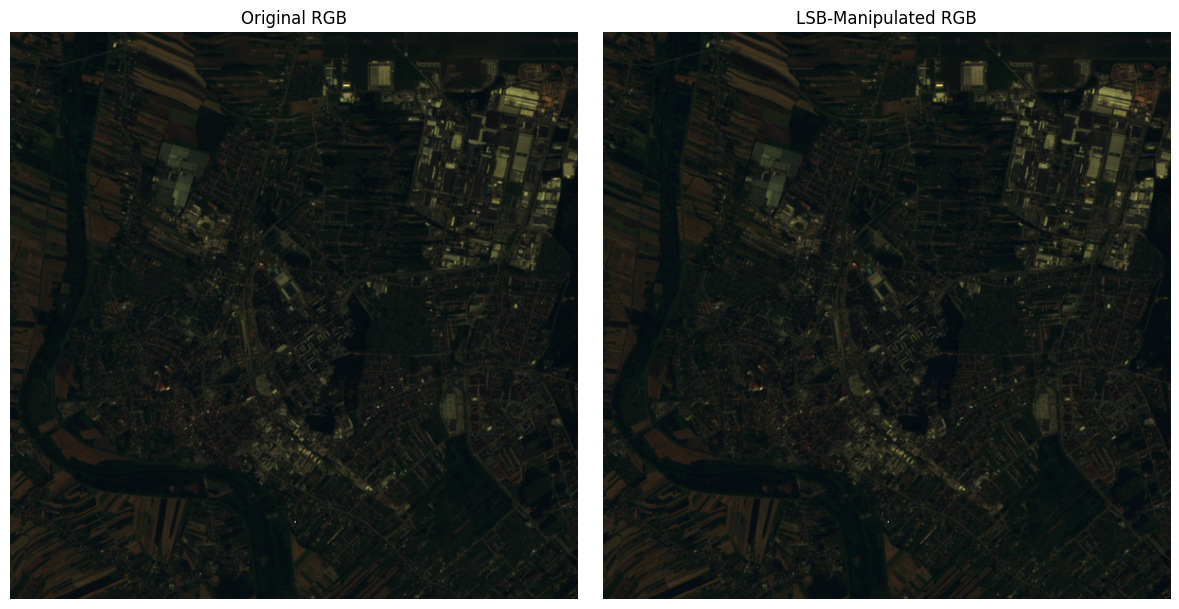

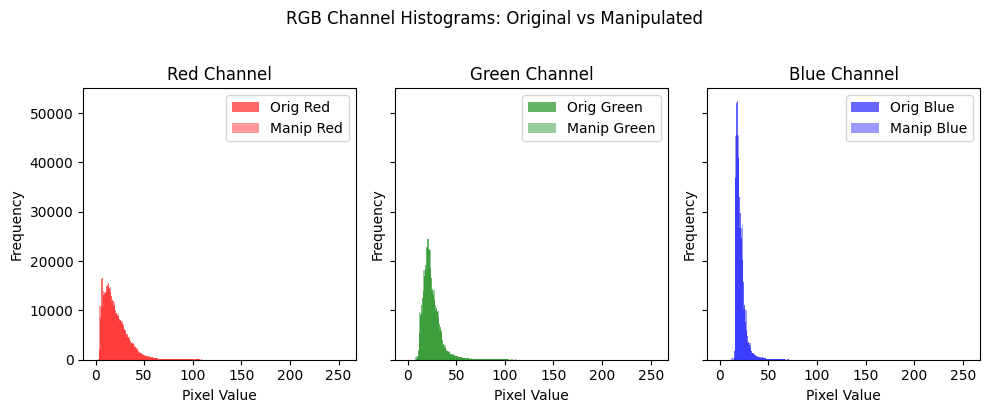

Mean pixel difference per channel: [1.24623611 1.25018056 1.23614444]
Max pixel difference per channel: [3 3 3]
Overall mean pixel difference: 1.2441870370370371


In [26]:
import numpy as np
import matplotlib.pyplot as plt

def normalize_to_uint8(band):
    band = band.astype(float)
    band = (band - band.min()) / (band.max() - band.min()) * 255
    return band.astype(np.uint8)

# Normalize each Sentinel-2 band to 8-bit
r = normalize_to_uint8(b4_crop_m)
g = normalize_to_uint8(b3_crop_m)
b = normalize_to_uint8(b2_crop_m)
rgb = np.dstack((r, g, b))

rng = np.random.default_rng()
random_bits = rng.integers(0, 4, size=rgb.shape, dtype=np.uint8)

# Insert random bits
manip = (rgb & 0b11111100) | random_bits

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(rgb)
plt.title("Original RGB")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(manip)
plt.title("LSB-Manipulated RGB")
plt.axis("off")
plt.tight_layout()
plt.show()

# Histogram comparison per channel as separate subplots
channel_info = [(0, "red", "Red"), (1, "green", "Green"), (2, "blue", "Blue")]
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True)
for ax, (i, color, name) in zip(axes, channel_info):
    ax.hist(rgb[..., i].ravel(), bins=256, alpha=0.6, label=f"Orig {name}", color=color)
    ax.hist(manip[..., i].ravel(), bins=256, alpha=0.4, label=f"Manip {name}", color=color)
    ax.set_xlabel("Pixel Value")
    ax.set_ylabel("Frequency")
    ax.set_title(f"{name} Channel")
    ax.legend(loc="upper right")
fig.suptitle("RGB Channel Histograms: Original vs Manipulated", y=1.02)
fig.tight_layout()
plt.show()

# Quantitative difference 
diff = np.abs(rgb.astype(int) - manip.astype(int))
print("Mean pixel difference per channel:", diff.mean(axis=(0,1)))
print("Max pixel difference per channel:", diff.max(axis=(0,1)))
print("Overall mean pixel difference:", diff.mean())


Visually, there’s no noticeable difference between the original image and the LSB-manipulated one. However, the histograms show that pixel values do change slightly. In theory, if we knew exactly what the pixel values or distributions should look like, we might be able to detect that an image was modified. The problem is that this would usually require access to the original image or some kind of reference. Also, the histograms only tell us that a difference exists, not which image is the altered one. If the labels “original” and “manipulated” were swapped, it would be impossible to tell which image is fake just by looking at them.